# Flow-based generative model 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch
import torch.nn as nn
import math

from torch.utils.data import DataLoader

import seaborn as sns

from sklearn.datasets import make_moons, make_circles, make_blobs

## Step 1, generate data.

We generate data by sampling a Brownian dynamics. 

We simply reuse the potential $V$ we studied before for Markov state models and learning eigenfunctions.

### 1.1. functions that define potential and sampling, and also set parameters

In [2]:
# potential V, one-dimensional
def V(x):
    y1 = x**8
    y2 = 0.8 * np.exp(-80 * x**2)
    y3 = 0.55 * np.exp(-80 * (x-0.5)**2)
    y4 = 0.3 * np.exp(-80 * (x+0.5)**2)

    y = 2 * (y1 + y2 + y3 + y4)

    return y

# gradient of V
def gradV(x):
    y1 = 8 * x**7 
    y2 = - 0.8 * 160 * x * np.exp(-80 * x**2)
    y3 = - 0.55 * 160 * (x - 0.5) * np.exp(-80 * (x-0.5)**2) 
    y4 = - 0.3 * 160 * (x + 0.5) * np.exp(-80 * (x+0.5)**2)

    y = 2 * (y1 + y2 + y3 + y4)

    return y

# sample the SDE using Euler-Maruyama scheme
def sample(beta=1.0, dt=0.001, N=10000, seed=42):
    rng = np.random.default_rng(seed=seed)
    X = 0.0
    traj = []
    tlist = []
    for i in range(N):
        traj.append(X)
        tlist.append(dt*i)        
        b = rng.normal()
        X = X - gradV(X) * dt + np.sqrt(2 * dt/beta) * b

    return np.array(tlist), np.array(traj)  

# coefficient in SDE
beta = 2.0
# step-size 
dt = 0.005
# number of sampling steps 
N = 10000
# range of the domain 
xmin, xmax = -1.0, 1.0

### 1.2 sample the SDE and display the trajectory 

**dataset** contains the training data we will use later.

From the figure on the right, we see that our target density has 4 modes.

dataset has 10000 states.



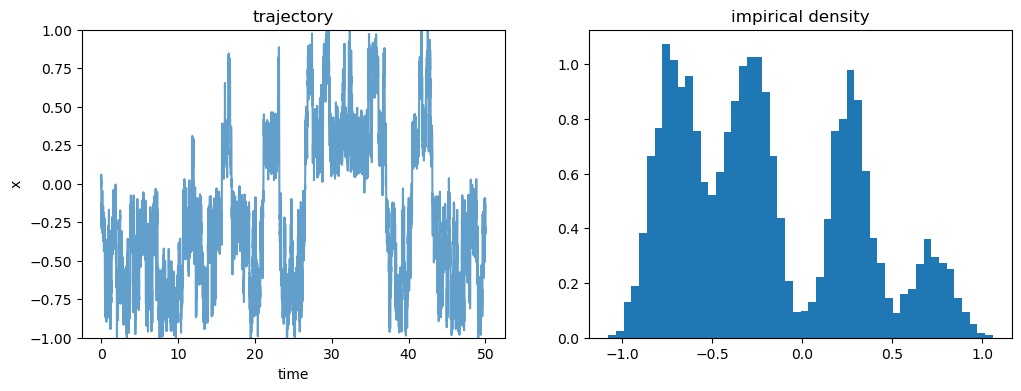

In [3]:
# sampling SDE
tvec, X = sample(beta, dt=dt, N=N)

# show how many states are sampled
print ('dataset has %d states.\n' % X.shape[0])

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)

# plot trajectory vs time
ax.plot(tvec, X, alpha=0.7)
ax.set_ylim([xmin, xmax])
ax.set_xlabel(r'time')
ax.set_ylabel(r'x')
ax.set_title('trajectory')

ax1 = fig.add_subplot(1, 2, 2)

# plot empirical density of the data
ax1.hist(X, 50, density=True)

ax1.set_title('impirical density')

plt.show()

### specify parameters  

In [25]:
# time interval is [0,1]
T = 1
N = 500
# step-size
dt = T/N
dim=2

### Define a neural network to model the vector field $u(x,t):\mathbb{R}^d \times [0,1] \rightarrow \mathbb{R}^d$


In [45]:
class MyScore(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 100),
            nn.Tanh(),
            nn.Linear(100, 100), 
            nn.Tanh(),                      
            nn.Linear(100, 100),             
            nn.Tanh(),            
            nn.Linear(100, 100), 
            nn.Tanh(),            
            nn.Linear(100, dim),             
       )
        
    
    def forward(self, x, t):
        
        # combine x and t into one tensor    
        state = torch.cat((x, t), dim=1)
        
        # pass input to the network
        output = self.net(state)
        
        return output
    
model = MyScore(dim)    

epoch=0
   loss=2.6664
epoch=100
   loss=1.7874
epoch=200
   loss=1.7501
epoch=300
   loss=1.7810
epoch=400
   loss=1.8094
epoch=500
   loss=1.6688
epoch=600
   loss=1.6782
epoch=700
   loss=1.8239
epoch=800
   loss=1.8174
epoch=900
   loss=1.6947
epoch=1000
   loss=1.6940
epoch=1100
   loss=1.7676
epoch=1200
   loss=1.6913
epoch=1300
   loss=1.5646
epoch=1400
   loss=1.6303
epoch=1500
   loss=1.6558
epoch=1600
   loss=1.7233
epoch=1700
   loss=1.6837
epoch=1800
   loss=1.7109
epoch=1900
   loss=1.6738
epoch=2000
   loss=1.5894
epoch=2100
   loss=1.6597
epoch=2200
   loss=1.7209
epoch=2300
   loss=1.5911
epoch=2400
   loss=1.7562
epoch=2500
   loss=1.6914
epoch=2600
   loss=1.5619
epoch=2700
   loss=1.6121
epoch=2800
   loss=1.6313
epoch=2900
   loss=1.5966
epoch=3000
   loss=1.7394
epoch=3100
   loss=1.6742
epoch=3200
   loss=1.6691
epoch=3300
   loss=1.6234
epoch=3400
   loss=1.7386
epoch=3500
   loss=1.6334
epoch=3600
   loss=1.7998
epoch=3700
   loss=1.6982
epoch=3800
   loss=1.575

Text(0.5, 1.0, 'loss vs epoch')

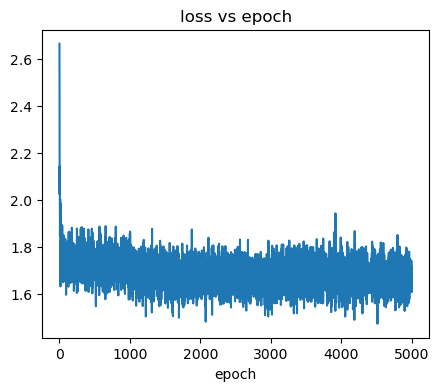

In [34]:
# batch-size
batch_size = 1000

# total training epochs
total_epochs = 5000

# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# change the dataset to PyTorch tensor
dataset = torch.tensor(X, dtype=torch.float32).reshape(-1,dim)

# define a dataloader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

loss_list = []

for epoch in range(total_epochs):   # for each epoch
    
    for idx, data in enumerate(data_loader):  # loop over all mini-batches 
        
        # for each state in mini-batch, uniformaly sample time on [0,1]
        t = torch.rand(data.shape[0], 1)  
         
        # generate standard Gaussian random variables
        x0 = torch.randn_like(data) 
        # 
        xt = (1-t) * x0 + t * data 

        # evaluate the model
        score = model(xt, t) 

        loss = torch.mean(torch.sum((score - (data - x0))**2, dim=1)) 
                        
        optimizer.zero_grad()
        # gradient step
        loss.backward()
        
        # update weights
        optimizer.step()
        
        if idx == 0:
            # record the loss    
            loss_list.append(loss.item())  
            if epoch % 100 == 0:
                print ('epoch=%d\n   loss=%.4f' % (epoch, loss.item()))   
                
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.plot(loss_list)
ax.set_xlabel('epoch')
ax.set_title('loss vs epoch')             

### display the neural network.

For the moment, the neural network has not been trained.

Text(0.5, 1.0, 'score function')

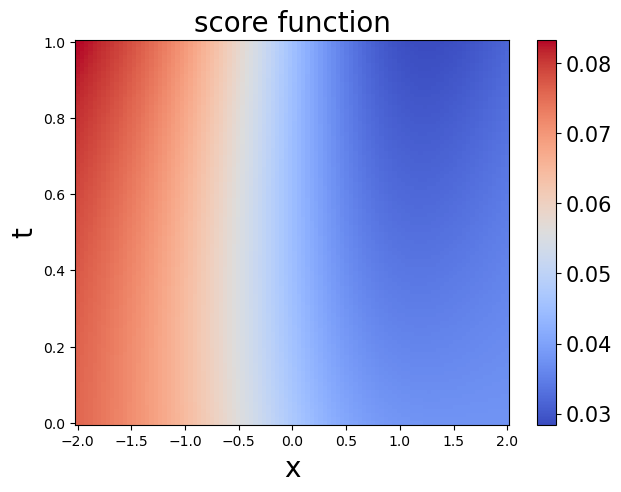

In [6]:
x = torch.linspace(-2, 2, 100)
t = torch.linspace(0, T, 100)
xv, tv = torch.meshgrid(x, t, indexing='ij')

score_xt = model(xv.reshape(-1, 1), tv.reshape(-1,1)).reshape(100,100)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1)

im = ax.pcolormesh(xv.numpy(), tv.numpy(), score_xt.detach().numpy(), cmap='coolwarm',shading='auto')

cbar = fig.colorbar(im, ax=ax, shrink=1.0)
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel(r'x',fontsize=20)
ax.set_ylabel(r't',fontsize=20)
ax.set_title('score function',fontsize=20)

In [37]:
from torchdiffeq import odeint

def sampling(N):
    
    def func(t,x):   
        return model(x, torch.ones(x.shape[0], 1) * t)
    
    x0 = torch.randn(N*dim).reshape(N, dim)

    t = torch.linspace(0,1,100)

    sol = odeint(func, x0, t)
    
    return sol

X_gen = sampling(5000).detach().numpy()

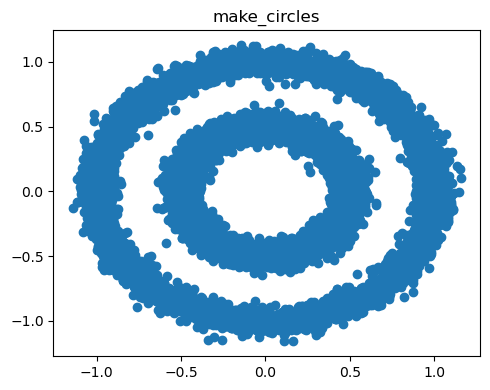

(10000, 2)


In [32]:
n_samples = 10000

X, Y = make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=170
)

fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.scatter(X[:, 0], X[:, 1])
ax.set_title("make_circles")

plt.tight_layout()
plt.show()

print (X.shape)

### display the (trained) score function.

### After learning the score function, we can generate new samples by simulating the backward process.

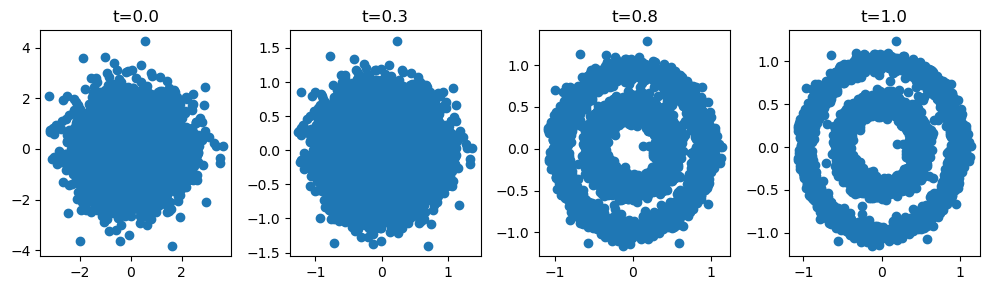

In [44]:

fig, ax = plt.subplots(1,4, figsize=(10, 3))

ax[0].scatter(X_gen[0, :, 0], X_gen[0, :, 1])
ax[0].set_title("t=0.0")

ax[1].scatter(X_gen[0, :, 0], X_gen[80, :, 1])
ax[1].set_title("t=0.3")

ax[2].scatter(X_gen[90, :, 0], X_gen[90, :, 1])
ax[2].set_title("t=0.8")

ax[3].scatter(X_gen[-1, :, 0], X_gen[-1, :, 1])
ax[3].set_title("t=1.0")

plt.tight_layout()
plt.show()

#sns.kdeplot(X_gen.flatten(), ax=ax, linestyle="--", bw_adjust=0.2, c='b', label='generated')

#plt.show()